In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco
from datetime import datetime

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2021-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Model Parameters
trading_days = 252
risk_free_rate = 0.04
num_portfolios = 25000

In [3]:
data = yf.download(tickers, start=start_date, end=end_date)['Close']

log_returns = np.log(data / data.shift(1)).dropna()

mean_returns_annual = log_returns.mean() * 252
cov_matrix_annual = log_returns.cov() * 252

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [ ]:
portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []
sharpe_ratios = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_weights.append(weights)

    returns = np.dot(weights, mean_returns_annual)
    portfolio_returns.append(returns)

    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))
    portfolio_volatility.append(volatility)

    sharpe = (returns - risk_free_rate) / volatility
    sharpe_ratios.append(sharpe)

results_data = {'Return': portfolio_returns, 'Volatility': portfolio_volatility, 'Sharpe Ratio': sharpe_ratios}
results_df = pd.DataFrame(results_data)

max_sharpe_portfolio = results_df.iloc[results_df['Sharpe Ratio'].idxmax()]
max_sharpe_weights = portfolio_weights[results_df['Sharpe Ratio'].idxmax()]

min_vol_portfolio = results_df.iloc[results_df['Volatility'].idxmin()]
min_vol_weights = portfolio_weights[results_df['Volatility'].idxmin()]

In [5]:
def portfolio_volatility_func(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return_func(weights, mean_returns, cov_matrix):
    return np.dot(weights, mean_returns)

In [6]:
# Przygotowanie zmiennych
frontier_volatility_list = []
# Tworzymy 100 poziomów zwrotu, od najniższego do najwyższego możliwego
target_returns = np.linspace(min(mean_returns_annual), max(mean_returns_annual), 100)
num_assets = len(tickers)
# Argumenty dla optymalizatora
args = (mean_returns_annual, cov_matrix_annual)
# Granice dla wag (każda waga od 0 do 1)
bounds = tuple((0, 1) for asset in range(num_assets))
# Początkowy, równy podział wag
initial_guess = num_assets * [1 / num_assets,]

In [7]:
# Pętla po każdym docelowym zwrocie, aby znaleźć minimalne ryzyko
for target_return in target_returns:
    # Definicja ograniczeń dla optymalizatora:
    # 1. Suma wag musi być równa 1.
    # 2. Zwrot portfela musi być równy docelowemu zwrotowi.
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: portfolio_return_func(x, mean_returns_annual, cov_matrix_annual) - target_return}
    )

    # Uruchomienie optymalizacji
    result = sco.minimize(
        fun=portfolio_volatility_func,
        x0=initial_guess,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    # Zapisanie wyniku (zmienności) dla danego zwrotu
    frontier_volatility_list.append(result['fun'])

In [ ]:
print("\n" + "-"*50)
print("Portfel o Maksymalnym Współczynniku Sharpe'a")
print("-"*50)
print(f"Oczekiwany roczny zwrot: {max_sharpe_portfolio['Return']:.2%}")
print(f"Roczna zmienność (ryzyko): {max_sharpe_portfolio['Volatility']:.2%}")
print(f"Współczynnik Sharpe'a: {max_sharpe_portfolio['Sharpe Ratio']:.2f}")
print("Wagi w portfelu:")
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {max_sharpe_weights[i]:.2%}")

print("\n" + "-"*50)
print("Portfel o Minimalnej Wariancji")
print("-"*50)
print(f"Oczekiwany roczny zwrot: {min_vol_portfolio['Return']:.2%}")
print(f"Roczna zmienność (ryzyko): {min_vol_portfolio['Volatility']:.2%}")
print(f"Współczynnik Sharpe'a: {min_vol_portfolio['Sharpe Ratio']:.2f}")
print("Wagi w portfelu:")
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {min_vol_weights[i]:.2%}")
print("\n" + "-"*50)


--------------------------------------------------
Portfel o Maksymalnym Współczynniku Sharpe'a
--------------------------------------------------
Oczekiwany roczny zwrot: 19.95%
Roczna zmienność (ryzyko): 25.69%
Współczynnik Sharpe'a: 0.62
Wagi w portfelu:
  AAPL: 9.02%
  MSFT: 0.72%
  GOOGL: 46.09%
  AMZN: 42.79%
  TSLA: 1.39%

--------------------------------------------------
Portfel o Minimalnej Wariancji
--------------------------------------------------
Oczekiwany roczny zwrot: 17.85%
Roczna zmienność (ryzyko): 24.33%
Współczynnik Sharpe'a: 0.57
Wagi w portfelu:
  AAPL: 36.82%
  MSFT: 1.40%
  GOOGL: 16.41%
  AMZN: 45.15%
  TSLA: 0.23%

--------------------------------------------------


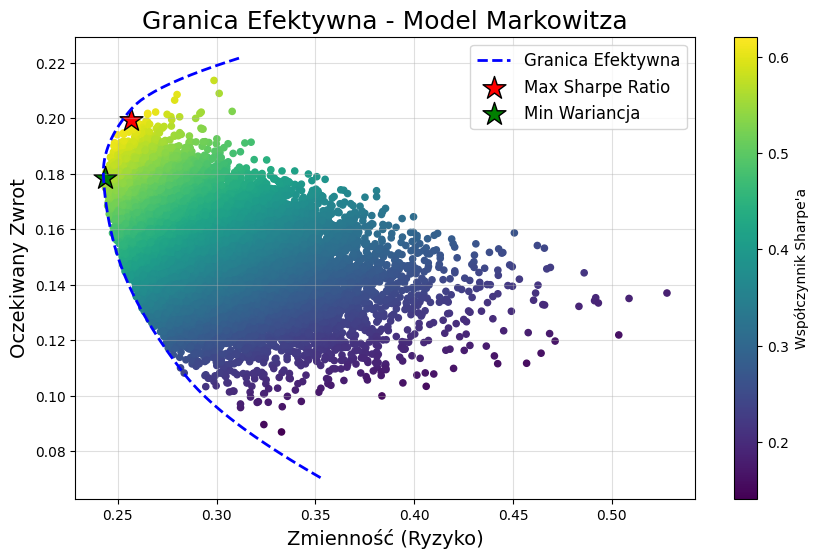

In [9]:
plt.figure(figsize=(10, 6))

# Wykres punktowy wszystkich symulowanych portfeli
scatter = plt.scatter(
    results_df['Zmienność'],
    results_df['Return'],
    c=results_df['Sharpe Ratio'],
    cmap='viridis',
    marker='o',
    s=20
)

# Rysowanie linii granicy efektywnej (NOWA LINIA KODU)
plt.plot(
    frontier_volatility_list,
    target_returns,
    'b--', # Niebieska, przerywana linia
    linewidth=2,
    label='Granica Efektywna'
)

# Zaznaczenie portfela o maksymalnym Sharpe Ratio (czerwona gwiazdka)
plt.scatter(
    max_sharpe_portfolio['Zmienność'],
    max_sharpe_portfolio['Return'],
    marker='*',
    color='red',
    s=300,
    label='Max Sharpe Ratio',
    edgecolors='black'
)

# Zaznaczenie portfela o minimalnej wariancji (zielona gwiazdka)
plt.scatter(
    min_vol_portfolio['Zmienność'],
    min_vol_portfolio['Return'],
    marker='*',
    color='green',
    s=300,
    label='Min Wariancja',
    edgecolors='black'
)

# Dodanie tytułu i etykiet osi
plt.title('Granica Efektywna - Model Markowitza', fontsize=18)
plt.xlabel('Zmienność (Ryzyko)', fontsize=14)
plt.ylabel('Oczekiwany Zwrot', fontsize=14)

# Dodanie paska kolorów i legendy
plt.colorbar(scatter, label="Współczynnik Sharpe'a")
plt.legend(loc='best', fontsize=12)

# Wyświetlenie wykresu
plt.grid(
    True,
    alpha = 0.4
)
plt.show()